In [1]:
!pip install tensorflow_io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 13.2 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
import tensorflow_io as tfio
import matplotlib.pyplot as plt
from IPython.display import Audio

filename = '00.mp3'

#частота дискритизации для работы
rate_out=16000
audio = tfio.audio.AudioIOTensor(filename)
print(audio)
audio_len = int(audio.shape[0])
# частота дискритизации исходника
rate = int(audio.rate)
start = 32000
audio_f = audio[start : audio_len-start]  # Обрежем тишину
wav = audio_f[:,0] # Берем только первый канал звука
wav = tfio.audio.resample(wav, rate_in=rate, rate_out=rate_out)

print(wav)

#Audio(wav, rate=rate_out)



<AudioIOTensor: shape=[31513103        1], dtype=<dtype: 'float32'>, rate=24000>
tf.Tensor(
[-2.8501111e-06  4.5242405e-06 -6.3414573e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00], shape=(20966068,), dtype=float32)


In [3]:
# Нарежем звук кратно 25 мс
smpl = wav.shape[0] // 400
len400 = 400*smpl
wav400 = wav[:len400]


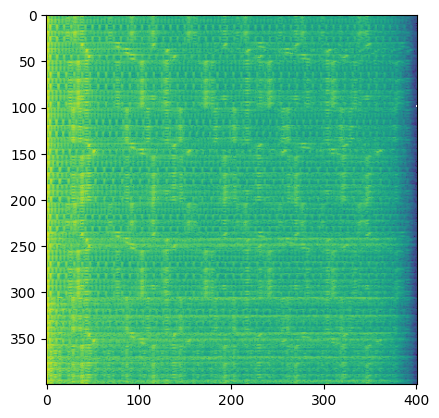

In [24]:

# Convert to spectrogram
# Окно 50 мс, шаг 25 мс
spectrogram = tfio.audio.spectrogram(wav400, nfft=800, window=800, stride=400)

plt.figure()
plt.imshow(tf.math.log(spectrogram[:400]).numpy())
Audio(wav400[:160000], rate=rate_out)

In [25]:
print(wav400.shape)
print(spectrogram.shape)

(20966000,)
(52415, 401)


(52415, 128)


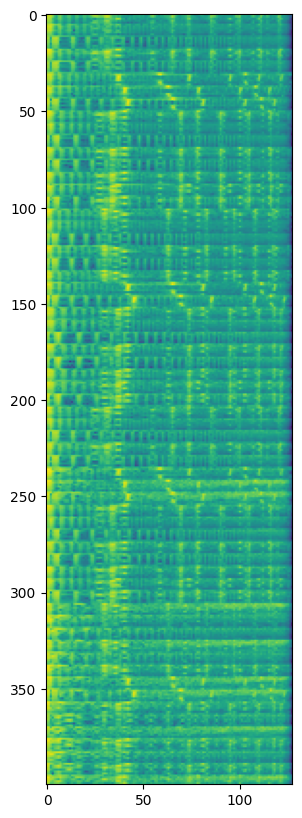

In [33]:
# Получим mel-спектр
mel_spectrogram = tfio.audio.melscale(spectrogram, rate=16000, mels=128, fmin=0, fmax=8000)
# Нормализуем
#dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=120)
print(mel_spectrogram.shape)
plt.figure(figsize=(5,10))
plt.imshow(tf.math.log(mel_spectrogram[:400]).numpy())

In [27]:
# Разделим данные по 25 мс
t2 = tf.reshape(wav400, [-1, 400])
len_train = int(0.9 * smpl)
y_train = t2[:len_train]
y_test = t2[len_train:]

X_train = mel_spectrogram[:len_train]
X_test = mel_spectrogram[len_train:]


In [38]:
model = tf.keras.Sequential()
# На вход подаем спектр
# На выходе исходнsq сигнал.
model.add(layers.Input(128))
model.add(layers.Dense(50))
model.add(layers.Dense(1))
model.add(layers.Dense(50))
model.add(layers.Dense(400))
model.summary()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=128, epochs=50)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 50)                6450      
                                                                 
 dense_25 (Dense)            (None, 1)                 51        
                                                                 
 dense_26 (Dense)            (None, 50)                100       
                                                                 
 dense_27 (Dense)            (None, 400)               20400     
                                                                 
Total params: 27001 (105.47 KB)
Trainable params: 27001 (105.47 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
369/369 [==============================] - 3s 5ms/step - loss: 0.0657 - accuracy: 0.0025
Epoch 2/50
369/369 [============================

In [44]:
y_dec = tf.reshape(y_train, [-1])
Audio(y_dec[:160000], rate=rate_out)

In [45]:
X_test_decoded = model.predict(X_train)
t_dec = tf.reshape(X_test_decoded, [-1])
Audio(t_dec[:160000], rate=rate_out)

1475/1475 [==============================] - 2s 1ms/step
